Author: Zidong Chen

Date: 2024/07/19

In [ ]:
import torch
import torch.nn as nn
from data_sample import generate_example_data as data
from matplotlib import pyplot as plt
import core.GP_CommonCalculation as GP
from core.kernel import RBFKernel, LinearKernel, ARDKernel,RationalQuadraticKernel, PeriodicKernel
import torch.optim as optim
from core.cigp_baseline import cigp
# I use torch (1.11.0) for this work. lower version may not work.
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Fixing strange error if run in MacOS
JITTER = 1e-6
EPS = 1e-10
PI = 3.1415

In [39]:
class NeuralKernel(nn.Module):
    def __init__(self, input_dim):
        super(NeuralKernel, self).__init__()

        # 定义核函数
        self.kernels = nn.ModuleDict({
            'RationalQuadratic': RationalQuadraticKernel(input_dim),
            'linear': LinearKernel(input_dim),
            'periodic': PeriodicKernel(input_dim),
            'ARD':ARDKernel(input_dim)
        })
        self.softplus= nn.Softplus()
        # 定义核函数的可学习权重
        self.weights = nn.ParameterDict({
            'RationalQuadratic': nn.Parameter(torch.tensor(1.0)),
            'linear': nn.Parameter(torch.tensor(1.0)),
            'periodic': nn.Parameter(torch.tensor(1.0)),
            'ARD':nn.Parameter(torch.tensor(1.0))
        })

    def forward(self, x1, x2):
        # 计算每个核函数的输出并加权相加
        K_sum = sum(self.softplus(self.weights[name]) * kernel(x1, x2)
                    for name, kernel in self.kernels.items())
        return K_sum

In [65]:
# generate example data
torch.manual_seed(0)
xtr=torch.rand(100,1)*10
ytr=torch.sin(xtr)+torch.randn_like(xtr)*0.1
xte=torch.linspace(0,10,1000).view(-1,1)
yte=torch.sin(xte)

In [66]:
x_dim= xtr.size(1)
NKGP=cigp(xtr, ytr,NeuralKernel(x_dim))
NKGP.train_adam(300,0.1)

iter 0 nll:295.43820
iter 10 nll:245.49470
iter 20 nll:197.54559
iter 30 nll:149.20049
iter 40 nll:102.29158
iter 50 nll:57.38380
iter 60 nll:15.24075
iter 70 nll:-13.96571
iter 80 nll:-29.67603
iter 90 nll:-33.74919
iter 100 nll:-36.93068
iter 110 nll:-32.42615
iter 120 nll:-29.84352
iter 130 nll:-32.32957
iter 140 nll:-34.43887
iter 150 nll:-35.77949
iter 160 nll:-36.73936
iter 170 nll:-37.30206
iter 180 nll:-37.68289
iter 190 nll:-37.91103
iter 200 nll:-38.05545
iter 210 nll:-38.14599
iter 220 nll:-38.21500
iter 230 nll:-38.26608
iter 240 nll:-38.31161
iter 250 nll:-38.22605
iter 260 nll:-38.09077
iter 270 nll:-37.52606
iter 280 nll:-37.69448
iter 290 nll:-38.21520


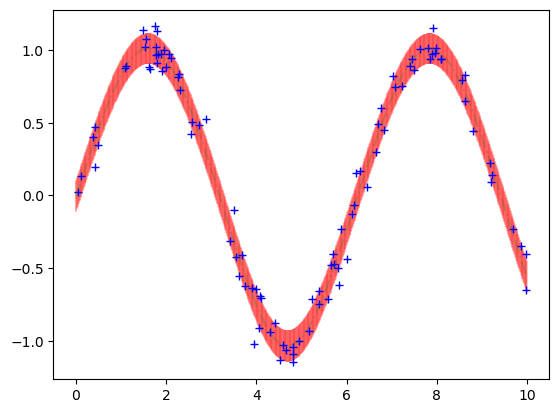

In [67]:
with torch.no_grad():
    ypred, yvar = NKGP.forward(xte)
plt.errorbar(xte.numpy().reshape(1000), ypred.detach().numpy().reshape(1000),
             yerr=yvar.sqrt().squeeze().detach().numpy(), fmt='-.', color='g', ecolor='red', alpha=0.2)
plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.show()

In [68]:
#Comparing with standard GP
standardGP=cigp(xtr, ytr,ARDKernel(1))
standardGP.train_adam(200,0.1)
with torch.no_grad():
    ypred2, yvar2 = standardGP.forward(xte)
mse_neuralKernel = ((yte - ypred) ** 2).mean()
mse_standardGP = ((yte - ypred2) ** 2).mean()
print('mse_neuralKernel:',mse_neuralKernel)
print('mse_standardGP:',mse_standardGP)

iter 0 nll:294.03428
iter 10 nll:245.67698
iter 20 nll:200.55881
iter 30 nll:163.87679
iter 40 nll:145.08915
iter 50 nll:144.90748
iter 60 nll:144.63995
iter 70 nll:143.69892
iter 80 nll:143.80934
iter 90 nll:143.69830
iter 100 nll:143.68075
iter 110 nll:143.67737
iter 120 nll:143.66957
iter 130 nll:143.57842
iter 140 nll:107.97238
iter 150 nll:63.32307
iter 160 nll:2.67293
iter 170 nll:-28.63332
iter 180 nll:-25.33856
iter 190 nll:-28.89366
mse_neuralKernel: tensor(0.0005)
mse_standardGP: tensor(0.0010)


In [69]:
for name, param in NKGP.kernel.weights.items():
    print(f"Weight for {name} kernel: {param.item()}")

Weight for ARD kernel: -5.04046400347627
Weight for RationalQuadratic kernel: -6.779714409190268
Weight for linear kernel: -6.421858626398856
Weight for periodic kernel: 1.5911262400959396


### Conclusion
#### The neural kernel demonstrated here is a linear combination of multiple kernels where the weights of each kernel are learned during training. The neural kernel can be used to model complex patterns in the data. In this example, the neural kernel is used to model a periodic function. The neural kernel is compared with the standard GP with ARD kernel. We can see that the neural kernel GP performs better than the standard GP in this example. The coefficients of each kernel are learned during training. After training, the weight for the periodic kernel is 1.59, and the weight of the other kernel is negative and close to zero after applying the softplus function. This aligns with the fact that the data is generated from a periodic function. This demonstrates that the neural kernel is a simple and effective way to automatically choose the kernel function for GP. You can change the data into a straight line to see how the neural kernel can automatically choose the linear kernel to model the data.